<a href="https://colab.research.google.com/github/karlssoj/compvis/blob/Exempel4_cats_dogs_classification_transfer_learning/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Klassificeringsexempel med faltningsnätverk (CNN) implementerat med Keras och Tensorflow </h1>

**Laddar ner cats & dogs dataset**

In [1]:
!wget  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2025-02-20 14:30:42--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.218.186.12, 2600:1409:3c00:681::317f, 2600:1409:3c00:688::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.218.186.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   108MB/s    in 9.7s    

2025-02-20 14:30:52 (81.1 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



**Packer upp ZIP-filen**

In [2]:
!unzip kagglecatsanddogs_5340.zip

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  

**Tar bort de "korrupta" bildfilerna**

In [3]:
!rm /content/PetImages/Cat/666.jpg
!rm /content/PetImages/Dog/11702.jpg

In [ ]:
import splitfolders

# Path to original dataset
input_folder = "/content/PetImages"  # The folder containing "Cat" and "Dog" subfolders

# Split into train (80%), validation (10%), and test (10%)
splitfolders.ratio(input_folder, output="PetImages_Split", seed=42, ratio=(0.8, 0.1, 0.1), group_prefix=None)

<b> 2. Importerar ImageDataGenerator från Keras-biblioteket för att kunna hantera träningsbilderna i X_O_training/o och X_O_training/x

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

<b> 4. Läser in alla träningsbilder på X och O från respektive kataloger i X_O_training-katalogen. Alla bilder får storleken 100x100 pixlar

In [5]:
train_image_gen = image_gen.flow_from_directory(
    "/content/PetImages/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=True
)

Found 24998 images belonging to 2 classes.


<b> 5. Träningsbilderna har automatiskt markerats enligt namnet på katalogerna de finns sparade i, dvs. O har labeln 0 och X har labeln 1

In [6]:
print(train_image_gen.class_indices)

{'Cat': 0, 'Dog': 1}


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

# Frys basmodellen så att dess vikter inte förändras under träningen
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)  # För att minska överanpassning

output_layer = Dense(1, activation="sigmoid")(x)  # Binary classification
model = Model(inputs=base_model.input, outputs=output_layer)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<b> 11. "Kompilerar" modellen. Optimizer är den metod man vill använda för att optimera alla vikter i nätet. Adam är en variant av gradient descent. Loss definierar "loss function", dvs. vad man vill använda för metod för att beräkna feluppskattningen under inträningen.

In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",  # Correct loss function for 2-class problem
    metrics=["accuracy"]
)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 224, 224, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,378,021 (16.70 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

<b> 12. Startar själva inträningen på testdataset:en. Epochs definierar hur många ggr inlärningsalgoritmen kommer att gå igenom hela dataset:en.

In [9]:
results = model.fit(train_image_gen, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
638/782 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.9774 - loss: 0.0573

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


782/782 ━━━━━━━━━━━━━━━━━━━━ 86s 80ms/step - accuracy: 0.9791 - loss: 0.0536
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - accuracy: 0.9914 - loss: 0.0258
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 78s 66ms/step - accuracy: 0.9929 - loss: 0.0210
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - accuracy: 0.9942 - loss: 0.0172
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - accuracy: 0.9943 - loss: 0.0164
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - accuracy: 0.9963 - loss: 0.0103
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 56s 72ms/step - accuracy: 0.9952 - loss: 0.0136
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - accuracy: 0.9964 - loss: 0.0094
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.9969 - loss: 0.0086
Epoch 10/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 66ms/step - accuracy: 0.9966 - loss: 0.0085


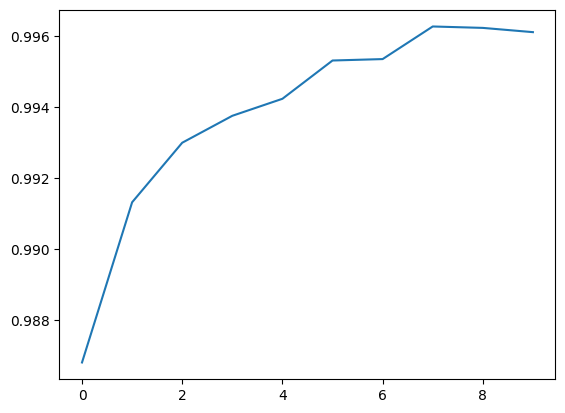

In [10]:
plt.plot(results.history['accuracy'])

<b> 13. Vi laddar in en testbild (En bild som inte finns i träningsdataset:en) för att se hur bra vår modell fungerar! Observera att i detta simpla exempel så måste X eller O täcka mer eller mindre hela bilden och bakgrunden bör (antagligen) vara vit för att det ska fungera. För att få modellen att hitta X eller O även om de är skrivna i mindre storlek och i olika bakgrunder så måste träningsdataset:en utökas.

In [ ]:
import numpy as np
import keras.utils as image
test_image = '/content/compvis/test_image1.jpg'
test_image = image.load_img(test_image, target_size=(100,100)) #laddar testbilden och sätter storleken till samma som träningsbilderna
test_image = image.img_to_array(test_image)                    #konverterar till array-format

test_image = np.expand_dims(test_image, axis=0)
test_image = test_image/255                                    #Ändrar pixelvärden från 8-bitar (0-255) till värden mellan 0 och 1

<b> 14. Vi startar "predikteringen" dvs. Som svar får vi konfidensvärden som berättar hur stor sannolikhten är att bilden innehåller ett X och hur stor sannolikheten är att bilden innehåller ett O

In [ ]:
prob = model.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [ ]:
print(prob)

[[0.84596676 0.12440345]]


In [ ]:
print("Sannolikheten att testbilden innehåller O: " + str(prob[0][0]))
print("Sannolikheten att testbilden innehåller X: " + str(prob[0][1]))

Sannolikheten att testbilden innehåller O: 0.84596676
Sannolikheten att testbilden innehåller X: 0.12440345
